<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [1]:
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

In [2]:
# Чтобы избежать отображение предупреждений.
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Параметры подключения к СУБД (закрытый характер).
connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [6]:
# текст запроса
query_3_1 = f'''SELECT
                    COUNT(*)
                FROM public.vacancies
             '''

In [7]:
# результат запроса
vac_df = pd.read_sql_query(query_3_1, connection)
vac_df

,count
0,49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [8]:
# текст запроса
query_3_2 = f'''SELECT
                    COUNT(*)
                FROM public.employers
             '''

In [9]:
# результат запроса
emp_df = pd.read_sql_query(query_3_2, connection)
emp_df

,count
0,23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [10]:
# текст запроса
query_3_3 = f'''SELECT
                    COUNT(*)
                FROM public.areas
             '''

In [11]:
# результат запроса
area_df = pd.read_sql_query(query_3_3, connection)
area_df

,count
0,1362


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [12]:
# текст запроса
query_3_4 = f'''SELECT
                    COUNT(*)
                FROM public.industries
             '''

In [13]:
# результат запроса
ind_df = pd.read_sql_query(query_3_4, connection)
ind_df

,count
0,294


***

**Выводы по предварительному анализу данных:**

В имеющейся базе данных `project_sql` количество вакансий примерно в 2 раза превалирует над количеством работодателей (*49197* против *23501*); количество регионов - *1362*; количетсво сфер деятельности работодателей - *294*.


# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [30]:
# текст запроса
query_4_1 = f'''SELECT
                    a.name area,
                    COUNT(DISTINCT v.id) cnt
                FROM public.vacancies v
                JOIN public.areas a ON a.id = v.area_id
                GROUP BY a.id
                ORDER BY 2 DESC
             '''

In [31]:
# результат запроса
cityvac_df = pd.read_sql_query(query_4_1, connection)
cityvac_df

,area,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
...,...,...
764,Кобрин,1
765,Духовщина,1
766,Новогрудок,1
767,Дорогобуж,1


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [32]:
# текст запроса
query_4_2 = f'''SELECT
                    COUNT(DISTINCT id)
                FROM public.vacancies
                WHERE 
                    salary_from IS NOT NULL OR
                    salary_to IS NOT NULL
             '''

In [33]:
# результат запроса
df = pd.read_sql_query(query_4_2, connection)
df

,count
0,24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [34]:
# текст запроса
query_4_3 = f'''SELECT
                    ROUND(AVG(salary_from)) "Low salary",
                    ROUND(AVG(salary_to)) "Upper salary"
                FROM
                    public.vacancies
            '''

In [35]:
# результат запроса
df = pd.read_sql_query(query_4_3, connection)
df

,Low salary,Upper salary
0,71065.0,110537.0


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [36]:
# текст запроса
query_4_4 = f'''SELECT
                    schedule,
                    employment,
                    COUNT(id)
                FROM public.vacancies
                GROUP BY 1, 2
                ORDER BY 3 DESC
             '''

In [37]:
# результат запроса
shed_emp_df = pd.read_sql_query(query_4_4, connection)
shed_emp_df

,schedule,employment,count
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [38]:
# текст запроса
query_4_5 = f'''SELECT
                    experience
                FROM public.vacancies
                GROUP BY 1
                ORDER BY COUNT(id)
             '''

In [39]:
# результат запроса
df = pd.read_sql_query(query_4_5, connection)
df

,experience
0,Более 6 лет
1,Нет опыта
2,От 3 до 6 лет
3,От 1 года до 3 лет


***

**Выводы по детальному анализу вакансий:**  

1. В представленных данных количество вакансий в порядке убывания распределяются следующим образом (топ 5 городов):

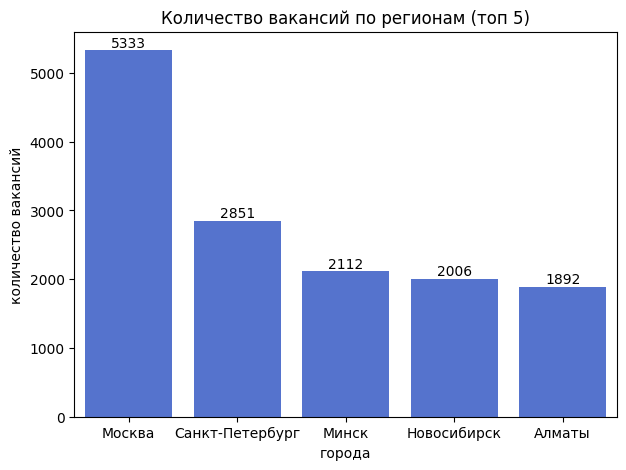

In [40]:
# Визуализация посредством столбчатой диаграммы.
fig = plt.figure(figsize=(7, 5))
barplot_df = cityvac_df.head()
barplot = sns.barplot(
    data=barplot_df,
    x='area',
    y='cnt',
    color='royalblue'
)

barplot.set_title('Количество вакансий по регионам (топ 5)')
barplot.set_xlabel('города')
barplot.set_ylabel('количество вакансий')
barplot.bar_label(barplot.containers[0], fontsize=10);

2. Из *49 197* вакансий только *24 073* (49 %) имеют отображение зарплатных показателей (`salary_from`, `salary_to`).

3. Нижние и верхние границы среднего значения зарплатной вилки – *71 065* и *110 537* соответственно.

4. Количество вакансий в зависимости от рабочего графика и типа трудойствройства является наибольшим при "полном дне и полной занятости" (*35 667*), а на втором месте – "удаленная работа полная занятость" (*7 802*).

5. Наибольшее количество вакансий имеет требование к опыту работы от 1 до 3 лет, при этом наименьшее количество вакансий ищет опыт работы более 6 лет, в отличие от отсутствия опыта в вакансии, который опережает предыдущий параметр.

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [41]:
# текст запроса
query_5_1 = f'''SELECT
                    e.name "работодатель"
                FROM
                    public.employers e
                    JOIN public.vacancies v ON e.id = v.employer_id
                GROUP BY 1
                ORDER BY COUNT(v.id) DESC
                LIMIT 5
             '''

In [42]:
# результат запроса
df = pd.read_sql_query(query_5_1, connection)
df

,работодатель
0,Яндекс
1,Ростелеком
2,Тинькофф
3,СБЕР
4,Газпром нефть


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [43]:
# текст запроса
query_5_2 = f'''SELECT
                    a.name "регион",
                    COUNT(DISTINCT e.id) "кол-во работодателей",
                    COUNT(DISTINCT v.id) "кол-во вакансий"
                FROM
                    public.areas a
                    LEFT JOIN public.employers e ON a.id = e.area
                    LEFT JOIN public.vacancies v ON a.id = v.area_id
                GROUP BY a.id
             '''

query_5_2_1 = f'''SELECT
                    a.name "регион",
                    COUNT(DISTINCT e.id) "кол-во работодателей",
                    COUNT(DISTINCT v.id) "кол-во вакансий"
                FROM
                    public.areas a
                    LEFT JOIN public.employers e ON a.id = e.area
                    LEFT JOIN public.vacancies v ON a.id = v.area_id
                WHERE
                    v.id IS NULL
                GROUP BY a.id
                ORDER BY 2 DESC
                LIMIT 1
             '''

In [44]:
# результат запроса
df_1 = pd.read_sql_query(query_5_2, connection)
df_2 = pd.read_sql_query(query_5_2_1, connection)

display(df_1)
display(df_2)

,регион,кол-во работодателей,кол-во вакансий
0,Москва,5864,5333
1,Санкт-Петербург,2217,2851
2,Екатеринбург,609,1698
3,Новосибирск,573,2006
4,Австралия,6,0
...,...,...,...
1357,Песчаное,0,0
1358,Усть-Абакан,0,0
1359,Белый Яр (Республика Хакасия),0,0
1360,Андреевка (Хасанский район),0,0


,регион,кол-во работодателей,кол-во вакансий
0,Россия,410,0


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [45]:
# текст запроса
query_5_3 = f'''SELECT
                    e.name "работодатель",
                    COUNT(DISTINCT v.area_id)
                FROM
                    public.employers e
                    LEFT JOIN public.vacancies v ON e.id = v.employer_id
                GROUP BY e.id
                ORDER BY 2 DESC
             '''

In [46]:
# результат запроса
df = pd.read_sql_query(query_5_3, connection)
df

,работодатель,count
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
...,...,...
23496,Но Смокинг,0
23497,МАСТЕРСКАЯ CREED,0
23498,Dzing Finance,0
23499,КОРС,0


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [47]:
# текст запроса
query_5_4 = f'''SELECT
                    COUNT(e.id)
                FROM 
                    public.employers e
                    LEFT JOIN public.employers_industries ei ON e.id = ei.employer_id
                WHERE
                    ei.industry_id IS NULL
             '''

In [48]:
# результат запроса
df = pd.read_sql_query(query_5_4, connection)
df

,count
0,8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [49]:
# текст запроса
query_5_5 = f'''SELECT
                    e.name
                FROM
                    public.employers e
                    JOIN public.employers_industries ei ON e.id = ei.employer_id
                GROUP BY e.id
                HAVING
                    COUNT(e.id) = 4
                ORDER BY 1
                OFFSET 2 LIMIT 1
             '''

In [50]:
# результат запроса
df = pd.read_sql_query(query_5_5, connection)
df

,name
0,2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [51]:
# текст запроса
query_5_6 = f'''SELECT
                    COUNT(ei.employer_id)
                FROM
                    public.employers_industries ei
                    JOIN public.industries i ON ei.industry_id = i.id
                WHERE
                    i.name = 'Разработка программного обеспечения'
             '''

In [52]:
# результат запроса
df = pd.read_sql_query(query_5_6, connection)
df

,count
0,3553


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [53]:
# код для получения списка городов-милионников посредством парсинга с библиотекой BS.
url = 'https://ru.wikipedia.org/wiki/Города-миллионеры_России'
response = requests.get(url)
page = BeautifulSoup(response.text, 'html.parser')
table = page.find('table', class_='standard sortable')
cities = []
for i in table.find_all('tr')[1:]:
    cities.append(i.find('a').text)

In [76]:
# текст запроса
query_5_7 = f'''WITH temp AS
                (SELECT
                    a.name,
                    COUNT(v.id) cnt
                FROM
                    public.areas a
                    JOIN public.vacancies v ON a.id = v.area_id
                    JOIN public.employers e ON e.id = v.employer_id
                WHERE
                    e.name = 'Яндекс' AND a.name IN {tuple(cities)}
                GROUP BY a.id
                ORDER BY 2)
                SELECT
                    temp.name,
                    temp.cnt
                FROM
                    temp
                UNION ALL
                SELECT
                    'Total',
                    SUM(temp.cnt)
                FROM
                    temp
             '''

In [77]:
# результат запроса
df_3 = pd.read_sql_query(query_5_7, connection)
df_3

,name,cnt
0,Омск,21.0
1,Челябинск,22.0
2,Красноярск,23.0
3,Волгоград,24.0
4,Ростов-на-Дону,25.0
5,Казань,25.0
6,Пермь,25.0
7,Самара,26.0
8,Уфа,26.0
9,Краснодар,30.0


***

**Выводы по анализу работодателей:**

1. Топ 5 работодателей по количеству вакансий расположены следующим образом в порядке убывания: Яндекс - Ростелеком - Тинькофф - СБЕР - Газпром нефть. Данный показатель свидетельствует о том, что рынок труда в большей мере занимают крупные компании с высоким уровнем цифровизации и широким распределением филиалов по регионам.

2. Распределение топ 5 регионов по количеству работодателей (имеющих вакансии) представлено на диаграмме ниже: 

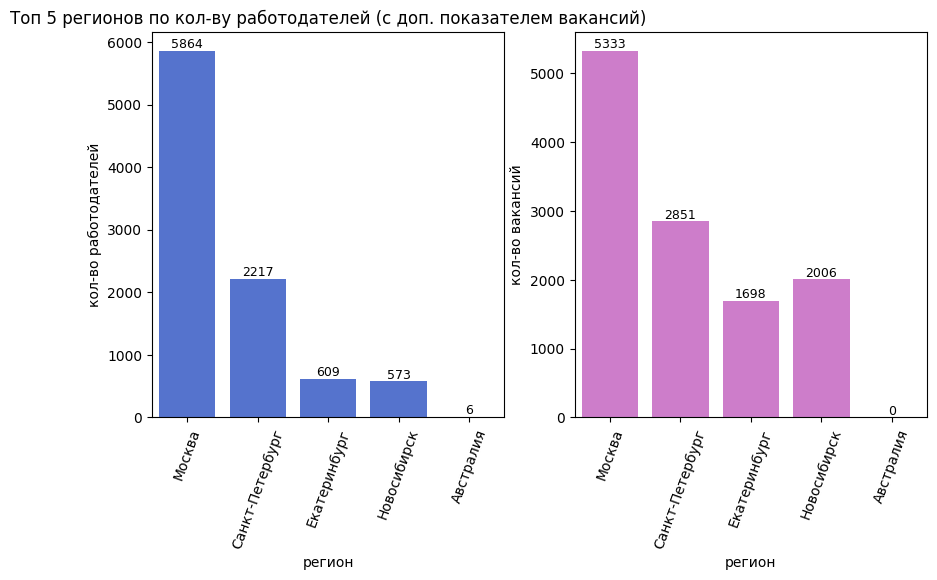

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

barplot1 = sns.barplot(
    data=df_1.head(),
    x='регион',
    y='кол-во работодателей',
    orient='v',
    ax = axes[0],
    color='royalblue'
)
barplot1.tick_params(axis='x', rotation=70)
barplot1.set_title('Топ 5 регионов по кол-ву работодателей (с доп. показателем вакансий)', fontsize=12)
barplot1.set_xlabel('регион', fontsize=10)
barplot1.set_ylabel('кол-во работодателей', fontsize=10)
barplot1.bar_label(barplot1.containers[0], fontsize=9)

barplot2 = sns.barplot(
    data=df_1.head(),
    x='регион',
    y='кол-во вакансий',
    orient='v',
    ax = axes[1],
    color='orchid'
)
barplot2.tick_params(axis='x', rotation=70)
barplot2.set_xlabel('регион', fontsize=10)
barplot2.set_ylabel('кол-во вакансий', fontsize=10)
barplot2.bar_label(barplot2.containers[0], fontsize=9);


При этом в *407* регионах (примерно *30 %* от общего числа) отсутствуют и работодатели и вакансии. Но среди регионов без вакансий наибольшее количество работодателей фиксируется в России.

3. Наибольший охват вакансий по регионам имеет Яндекс (*181*), что подтвердает тезис, выдвинутый в п. 1.

4. Сфеара деятельности не указана у *8419* работодателей.

5. Разработкой программного обеспечения занимается *3553* работодателя, что составляет примерно *15 %* от общего количества работодателей. Данный показатель свидетельствует о том, что более *1/10* части работодателей представляют активные услуги в сфере ИТ, что также оказывает положительное влияние на уровень цифровизации экономики.

6. Распределение вакансий компании Яндекс в городах-миллионниках выглядит следующим образом:

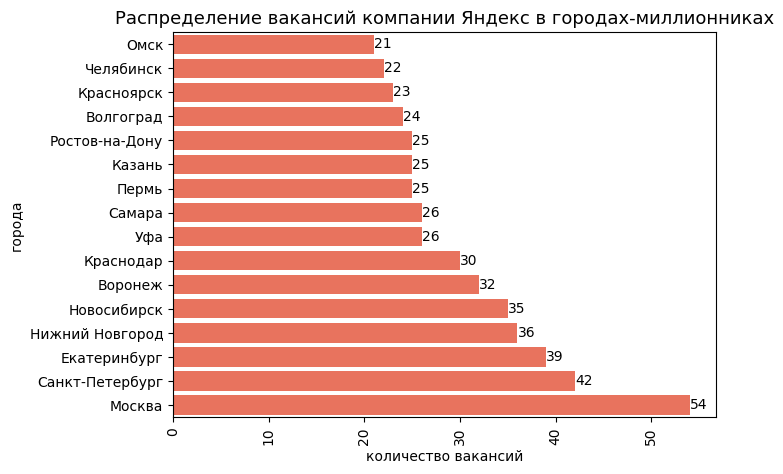

In [78]:
fig = plt.figure(figsize=(7, 5))

barplot = sns.barplot(
    data=df_3.iloc[:-1],
    x='cnt',
    y='name',
    color='tomato',
    orient='h'
)

barplot.set_title('Распределение вакансий компании Яндекс в городах-миллионниках', fontsize=13)
barplot.set_ylabel('города')
barplot.set_xlabel('количество вакансий')
barplot.bar_label(barplot.containers[0], fontsize=10)
barplot.tick_params(axis='x', rotation=90)

Данный показатель успешности Яндекса в Москве (а также в СпБ) обусловлен высоким уровнем цифровой инфраструктуры в указанных городах, а также большим количеством ВУЗов, что способствует наличию большого количества молодых специалистов. 

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [79]:
# текст запроса
query_6_1 = f'''SELECT
                    COUNT(id)
                FROM
                    public.vacancies
                WHERE
                    (lower(name) LIKE '%data%') OR (lower(name) LIKE '%данн%')
             '''

In [80]:
# результат запроса
df = pd.read_sql_query(query_6_1, connection)
df

,count
0,1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [81]:
# текст запроса
query_6_2 = f'''SELECT
                    COUNT(id)
                FROM
                    public.vacancies
                WHERE
                    (lower(name) LIKE '%data scientist%' OR 
                    lower(name) LIKE '%data science%' OR
                    lower(name) LIKE '%исследователь данных%' OR
                    lower(name) LIKE '%ml%' AND lower(name) NOT LIKE '%html%' OR
                    lower(name) LIKE '%machine learning%' OR
                    lower(name) LIKE '%машинн%обучен%') AND
                    (lower(name) LIKE '%junior%' OR
                    experience = 'Нет опыта' OR
                    employment = 'Стажировка')
             '''

In [82]:
# результат запроса
df = pd.read_sql_query(query_6_2, connection)
df

,count
0,51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [83]:
# текст запроса
query_6_3 = f'''SELECT
                    COUNT(id)
                FROM
                    public.vacancies
                WHERE
                    (lower(name) LIKE '%data scientist%' OR 
                    lower(name) LIKE '%data science%' OR
                    lower(name) LIKE '%исследователь данных%' OR
                    lower(name) LIKE '%ml%' AND lower(name) NOT LIKE '%html%' OR
                    lower(name) LIKE '%machine learning%' OR
                    lower(name) LIKE '%машинн%обучен%') AND
                    (lower(key_skills) LIKE '%sql%' OR lower(key_skills) LIKE'%postgres%')
             '''

In [84]:
# результат запроса
df = pd.read_sql_query(query_6_3, connection)
df

,count
0,229


4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [85]:
# текст запроса
query_6_4 = f'''SELECT
                    COUNT(id)
                FROM
                    public.vacancies
                WHERE
                    (lower(name) LIKE '%data scientist%' OR 
                    lower(name) LIKE '%data science%' OR
                    lower(name) LIKE '%исследователь данных%' OR
                    lower(name) LIKE '%ml%' AND lower(name) NOT LIKE '%html%' OR
                    lower(name) LIKE '%machine learning%' OR
                    lower(name) LIKE '%машинн%обучен%') AND
                    (lower(key_skills) LIKE '%python%')
             '''

In [86]:
# результат запроса
df = pd.read_sql_query(query_6_4, connection)
df

,count
0,357


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [87]:
# текст запроса
query_6_5 = f'''SELECT
                    round(AVG(length(key_skills) - length(replace(key_skills, CHR(9), ''))+1), 2)
                FROM
                    public.vacancies
                WHERE
                    lower(name) LIKE '%data scientist%' OR 
                    lower(name) LIKE '%data science%' OR
                    lower(name) LIKE '%исследователь данных%' OR
                    name LIKE '%ML%' AND name NOT LIKE '%HTML%' OR
                    lower(name) LIKE '%machine learning%' OR
                    lower(name) LIKE '%машинн%обучен%'
             '''

In [88]:
# результат запроса
df = pd.read_sql_query(query_6_5, connection)
df

,round
0,6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [89]:
# текст запроса
query_6_6 = f'''SELECT
                    experience,
                    ROUND(AVG(COALESCE((salary_from + salary_to) / 2, salary_from, salary_to)), 0)
                FROM
                    public.vacancies
                WHERE
                   (lower(name) LIKE '%data scientist%' OR 
                    lower(name) LIKE '%data science%' OR
                    lower(name) LIKE '%исследователь данных%' OR
                    name LIKE '%ML%' AND name NOT LIKE '%HTML%' OR
                    lower(name) LIKE '%machine learning%' OR
                    lower(name) LIKE '%машинн%обучен%') AND
                    (salary_from IS NOT NULL OR
                    salary_to IS NOT NULL)
                GROUP BY 1
             '''

In [90]:
# результат запроса
df_4 = pd.read_sql_query(query_6_6, connection)
df_4

,experience,round
0,Нет опыта,74643.0
1,От 1 года до 3 лет,139675.0
2,От 3 до 6 лет,243115.0


***

**Выводы по предметному анализу:**

1. Из более чем *49* тыс представленных в данных ваканский *1771* относится к профессиям, связанным с *DataScience*, что составляет примерно *3 %* от их общего количества. Данный показатель свидетельствует о доволно большом спросе на указанное направвление среди прочих.

2. При этом начинающий специалист в *DS* представлен только в *51* вакансии, что свидетельствует о постепенном насыщении рынка опытными специалистами в этой сфере, но в то же время доступность данной профессии на "нулевом входе" остается на удовлетворительном уровне.

3. Среди наиболее распространенных требуемых навыков в вакансиях *DS* числятся владение языками программирования *Python*, *SQL*. Так, например, иные популярные языки, такие как *Java* и *C++* представлены в вакансиях в ***5(!)*** раз меньше, что свидетельствует об их постепенном моральном устаревании.

4. В среднем в сфере *DS* в вакансиях указывается *6* ключевых навыков, при этом аналогичное среднее значение данного признака наблюдается и в остальных вакансиях, не связанных с *DS*.

5. В зависимости от опыта работы средняя зарплата специалистов *DS* представлена следующим образом:

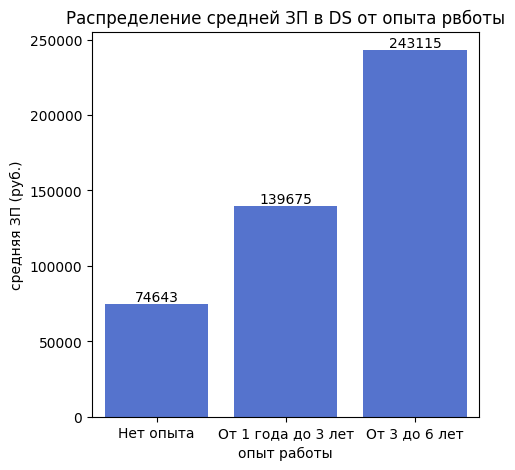

In [91]:
fig = plt.figure(figsize=(5, 5))
barplot = sns.barplot(
    data=df_4,
    x='experience',
    y='round',
    color='royalblue'
)

barplot.set_title('Распределение средней ЗП в DS от опыта рвботы')
barplot.set_xlabel('опыт работы')
barplot.set_ylabel('средняя ЗП (руб.)')
barplot.bar_label(barplot.containers[0], fontsize=10);

Указанное распределение условно соответствует разнице ЗП среди *Junior*-специалиста, *Mid*'а и *Senior*'а в сфере *DS*. При этом наблюдается равное пропорция увеличения оклада при переходе из одной категории специалиста в другую - зарплата увеличивается примерно в *1.8* раз, что способно в должной мере стимулировать спрос на данные вакансии.

# Общий вывод по проекту

В рамках дополнительного исследования данных о вакансиях производим запрос, который позволит узнать 3 наиболее распространенные сферы деятельности работодателей:

In [92]:
# Текст запроса.
query_extra_1 = f'''SELECT
                    i.name "сфера деятельности",
                    COUNT(v.id) "кол-во"
                FROM
                    public.vacancies v
                    JOIN public.employers e ON e.id = v.employer_id
                    JOIN public.employers_industries ei ON e.id=ei.employer_id
                    JOIN public.industries i ON i.id = ei.industry_id
                GROUP BY i.id
                ORDER BY 2 DESC
                LIMIT 3
             '''
 
#  Результат запроса.            
df_extra_1 = pd.read_sql_query(query_extra_1, connection)
df_extra_1

,сфера деятельности,кол-во
0,Разработка программного обеспечения,12499
1,"Системная интеграция, автоматизации технологи...",11034
2,"Интернет-компания (поисковики, платежные систе...",6413


По результатам провежденного анализа данных о вакансиях можно сделать обобщенный вывод, что наибольшее количество вакансий представленны от компании Яндекс в Москвоском регионе (как и прочих работодателей); общие (у всех работодателей) требования опыта работы преимущественно составляют от 1 до 3 лет; занятость и график - полный днень и полная занятость; наиболее широко представлены вакансии следующих сфер деятельности по убыванию: разработка ПО – Системная интеграция, автоматизация, ИТ-консалтинг – интернет-компания. Все вышеперечисленные факторы свидетельствуют о восходящем уровне цифровизации экономики, что явно прослеживается в представленных данных.

Наибольшее количество вакансий представлено в городах-миллионниках, что обусовленно соответствующим высоким экономических уровнем данных регионов, увязанным с количеством населения. Также в результате выполнения запроса ниже установлено, что средняя зарплата по представленным вакансиям выше в старанах Европы и составляет в наивысшем значении около *450 000* руб.:

In [93]:
# Текст запроса.
query_extra_2 = f'''SELECT
                    a.name "регион",
                    ROUND(AVG(COALESCE((v.salary_from + v.salary_to) / 2, v.salary_from, v.salary_to))) "средняя ЗП"
                FROM
                    public.vacancies v
                    JOIN public.areas a ON a.id = v.area_id
                WHERE
                    v.salary_from IS NOT NULL OR v.salary_to IS NOT NULL
                GROUP BY a.id
                ORDER BY 2 DESC
                LIMIT 5
             '''

# Результат запроса.
df_extra_2 = pd.read_sql_query(query_extra_2, connection)
df_extra_2

,регион,средняя ЗП
0,Германия,452751.0
1,Болгария,324348.0
2,Испания,300000.0
3,Черногория,288589.0
4,Литва,263019.0


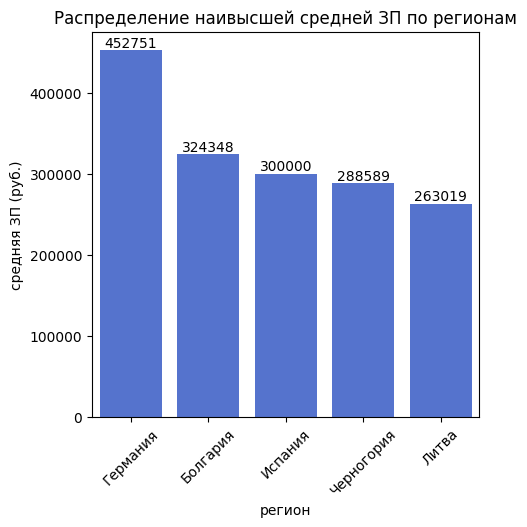

In [94]:
# Визуализация вывода вышеуказанного запроса.
fig = plt.figure(figsize=(5, 5))
barplot = sns.barplot(
    data=df_extra_2,
    x='регион',
    y='средняя ЗП',
    color='royalblue'
)

barplot.tick_params(axis='x', rotation=45)
barplot.set_title('Распределение наивысшей средней ЗП по регионам')
barplot.set_xlabel('регион')
barplot.set_ylabel('средняя ЗП (руб.)')
barplot.bar_label(barplot.containers[0], fontsize=10);

Также, в рамках дополнительного анализа вызывем нижеуказанный запрос, который позволяет вывести количество вакансий с требованием знания иностранных языков, таких как английский и китайский соответственно:

In [95]:
# Текст запроса.
query_extra_3 = f'''SELECT
                    'Английский' "ин. язык",
                    COUNT(v.id) "кол-во вак-ий"
                FROM
                    public.vacancies v
                WHERE
                    lower(v.key_skills) LIKE '%английск%яз%'
                UNION ALL
                SELECT
                    'Китайский',
                    COUNT(v.id)
                FROM
                    public.vacancies v
                WHERE
                    lower(v.key_skills) LIKE '%китайск%яз%'
             '''
             
# Результат запроса.
df_extra_3 = pd.read_sql_query(query_extra_3, connection)
df_extra_3

,ин. язык,кол-во вак-ий
0,Английский,4650
1,Китайский,7


Вышеуказанные результаты свидетельствуют о сохранении английского языка как средства международного профессионального взаимодействия, требуемого работодателем. Китайский язык же как требование к соискателю имеют карйне малое число вакансий (только *7* против *4650* с англ. яз-м). Также, с учетом полученных результатов о доминировании вакансий от работодателей, связанных со сферой разработки ПО, указанное соотношение является закономерным, т.к. все языки программирования пишутся на английском. При этом, вакансии, предполагающие знание китайского языка в основном представлены в регионах/городах, непосредственно граничащих с Китайской Народной Республикой, что видно при исполнении запроса ниже:

In [96]:
# Текст запроса.
query_extra_4 = f'''SELECT
                    a.name "регион",
                    COUNT(v.id) "кол-во вак-й"
                FROM
                    public.vacancies v
                    JOIN public.areas a ON a.id = v.area_id
                    --JOIN public.employers e ON e.id = v.employer_id
                    --JOIN public.employers_industries ei ON e.id=ei.employer_id
                    --JOIN public.industries i ON i.id = ei.industry_id
                WHERE
                    lower(v.key_skills) LIKE '%китайск%яз%'
                GROUP BY a.id
                ORDER BY 2 DESC
             '''
 
#  Результат запроса.            
df_extra_4 = pd.read_sql_query(query_extra_4, connection)
df_extra_4

,регион,кол-во вак-й
0,Москва,1
1,Благовещенск (Амурская область),1
2,Иркутск,1
3,Нижний Новгород,1
4,Алматы,1
5,Минск,1
6,Ангарск,1


In [97]:
# Заканчиваем соединение с сервером.
connection.close()

Данные, представленные по итогу исполнения двух последних запросов, свидетельствуют о крайне малом количестве вакансий, требующих знание китайского языка, в т.ч. в России. Однако, в настоящее время наблюдается сильная активизация экономического взаимодействия с КНР, что повлечет за собой портебность в знании российскими специалистами данного иностранного языка (граждане Китая, как показывает статистика, в малом количестве знают английский). На основании изложенного полагается целесообразным рекомендовать работодателям рассматривать так же приобретение специалистов со знанием данного языка, особенно контактирующих с партнерами из КНР.